In [40]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import cvxpy as cp

In [41]:
np.random.seed(42)

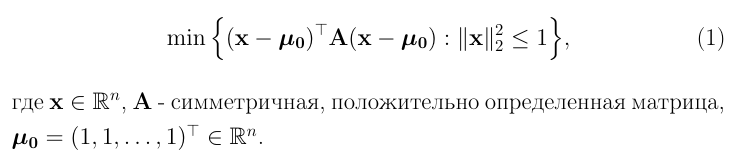

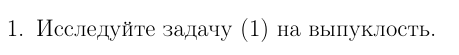

Функция $f(x)$ является квадратичной формой относительно $x$. 
Гессиан (вторая производная) этой функции $H(x) = 2A$. По условию матрица $A$ положительно определена, а значит и матрица $2A$ тоже положительно определена. Из этого следует, что функция $f(x)$ является выпуклой.

Ограничение можно записать как $g(x) = x^Tx \le 1$. Первая производная равна $2x$, а гессиан равен $2I$, где $I$ - единичная матрица. $2I$ положительно определена, а значит $g(x)$ - выпуклая функция. Из этого следует, что и ограничение $g(x) \le 1$ - выпуклое множество. Также можно сказать, что это это множество соответствует единичному шару в $\mathbb{R}^n$.

Таким образом, поскольку и функция цели, и множество ограничений выпуклы, оптимизационная задача является выпуклой.

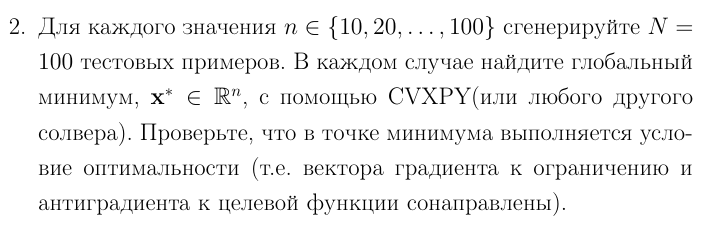

In [42]:
def cp_rand_elipsoids(n_dim: int = 2, n_samples: int = 100, random_states: list = None):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]

    cases = []

    for A in affine_ops:

        x = cp.Variable(n_dim)

        objective = cp.Minimize(cp.quad_form(x - mu, A))

        constraints = [cp.norm(x) <= 1]

        prob = cp.Problem(objective, constraints)

        result = prob.solve()

        cases.append((A, x.value, result))

    return cases

In [43]:
def ensure_optim(affine_operator, opt_point_candidate, eps=0.1):
    anti_grad_quadform = -(
        (affine_operator + affine_operator.T) @ opt_point_candidate
        - (affine_operator + affine_operator.T) @ np.ones_like(opt_point_candidate)
    )
    grad_constraint = opt_point_candidate * 2

    cos_sim = np.dot(anti_grad_quadform, grad_constraint) / (
        np.linalg.norm(anti_grad_quadform) * np.linalg.norm(grad_constraint)
    )

    return np.abs(cos_sim - 1) < eps

In [44]:
for c in cp_rand_elipsoids(10):
    print(ensure_optim(c[0], c[1]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
